## Dueling Double Deep Q-Network With Prioritized Experience Replay (Dueling DQN_PER)
---

Based on works from: [1](https://github.com/udacity/deep-reinforcement-learning), [2](https://github.com/andreidi/DDPG-TD3-PER/blob/master/per.py), [3](https://github.com/muhamuttaqien/AI-Lab/blob/master/deep-learning/reinforcement-learning/deep-q-learning/per-dqn/lunar-lander/pytorch-per-dqn.ipynb), [4](https://github.com/YijiongLin/Udacity_DRL_NanoDegree)

#### Import the Necessary Packages

In [1]:
import gym, random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import functools, operator

#### Set Configuration

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

#### Define Q-Network Architecture

In [6]:
class Dueling_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(Dueling_QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # value layer
        self.fc_vlayer = nn.Linear(fc2_units, 1)
        # advantage layer
        self.fc_alayer = nn.Linear(fc2_units, action_size)
        
    
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc_vlayer(x)
        advantage = self.fc_alayer(x)
        advantage_mean = advantage.mean(1).unsqueeze(1)
        # Combine the value and advantage streams to final output.
        # Normalized a with minus a.mean
        Qsa = value + (advantage - advantage_mean)
        return Qsa

#### Define Prioritized Replay Buffer

In [7]:
class NaivePrioritizedReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size):
        
        self.alpha = 0.6                               # this constant controls the prioritization, (0: hard prioritization, 1: uniform sampling)
        self.beta = 0.4                                # this constant controls the IS (Importance Sampling constant), (0: hard importance, 1: uniform importance)
        self.epsilon = 0.01                              # this constant add small priority to avoid 0 opportunity experience to get taken
        self.beta_increment_per_sampling = 0.001
        self.absolute_error_upper = 1.                 # clipped abs error
        
        self.memory = deque(maxlen=buffer_size)  
        self.priorities = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        max_priority = max(self.priorities) if self.memory else 1.0
        
        self.memory.append(e)
        self.priorities.append(max_priority)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs/= probs.sum() 
        
        indices = np.random.choice(len(self.memory), BATCH_SIZE, p=probs)
        experiences = [self.memory[index] for index in indices]
        
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling]) 
        
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        weights/= weights.max()
        weights = np.array(weights, dtype=np.float32).reshape((-1,1))
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        weights = torch.from_numpy(weights).float().to(device)
        
        return indices, (states, actions, rewards, next_states, dones), weights
    
    def priority_batch_update(self, batch_indices, batch_priorities):
        """Update prioritied for every batch."""
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = np.minimum(prio + 1e-5, 1.)[0]          # find out why the batch prio is in list, for now this should do

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.memory_size = BUFFER_SIZE
        self.discount_factor = 0.99
        self.learning_rate = LR
        
        # Q-Network
        self.qnetwork_local = Dueling_QNetwork(state_size, action_size, seed).to(device)              # some call this the expected network
        self.qnetwork_target = Dueling_QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
        
        # Replay memory
        self.memory = NaivePrioritizedReplayBuffer(self.memory_size)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                indices_batch, experience_batch, is_weights = self.memory.sample()
                self.learn(indices_batch, experience_batch, is_weights, GAMMA)                
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()                      # this change the local net to eval mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()                     # this just return the local net back to train mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, indices_batch, experience_batch, is_weights, gamma):
        """Update value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experience_batch
        
        #################################################################################################################################################
        # Get max predicted Q values (for next states) from target model
        qsa_next = self.qnetwork_local(next_states).detach()
        _, action_max = qsa_next.max(1)
        target_q_next = self.qnetwork_target(next_states).detach().gather(1, action_max.unsqueeze(1))                                   # double dqn part
        
        
        """
        Vanilla DQN
        target_q_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)       # this use epsilon greedy
        """
        #################################################################################################################################################
        
        # Compute Q targets for current states 
        target_q = rewards+(gamma*target_q_next*(1-dones))
                            
        # Get expected Q values from local model
        expected_q = self.qnetwork_local(states).gather(1, actions)

        # Compute loss using PER concept
        loss  = torch.pow((expected_q - target_q), 2) * is_weights        
        priorities = loss + self.memory.epsilon
        
        loss  = torch.mean(loss)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
                            
        # Update Buffer Priorities
        self.memory.priority_batch_update(indices_batch, priorities.data.cpu().numpy())

            
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
        return loss

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

#### Instantiate the Environment and Agent

In [9]:
env = gym.make('CartPole-v1')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

agent = Agent(state_size=4, action_size=2, seed=0)

State shape:  (4,)
Number of actions:  2


#### Instantiate the Environment and Agent
Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [10]:
def dqn_per(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning with Naive Prioritized Experience Replay."""
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [11]:
# train the agent
scores = dqn_per(n_episodes=2000, max_t=1000)

Episode 100	Average Score: 20.40
Episode 200	Average Score: 14.39
Episode 300	Average Score: 12.11
Episode 400	Average Score: 11.83
Episode 500	Average Score: 12.68
Episode 600	Average Score: 14.18
Episode 700	Average Score: 25.91
Episode 800	Average Score: 120.37
Episode 900	Average Score: 199.25
Episode 907	Average Score: 200.03
Environment solved in 807 episodes!	Average Score: 200.03


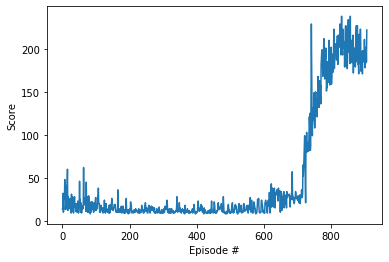

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Simulate Emulator

1. using replay buffer
2. using random walk + successful run

In [92]:
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [37]:
replay_buffer = list(agent.memory.memory)

In [56]:
replay_buffer[0]

Experience(state=array([-0.04456399,  0.04653909,  0.01326909, -0.02099827]), action=1, reward=1.0, next_state=array([-0.04363321,  0.24146826,  0.01284913, -0.30946528]), done=False)

In [104]:
# replay buffer component
state = pd.DataFrame([i[0] for i in np.array(replay_buffer)], columns=['S1','S2','S3','S4'])
action = pd.DataFrame([i[1] for i in np.array(replay_buffer)], columns=['A'])
reward = pd.DataFrame([i[2] for i in np.array(replay_buffer)], columns=['R'])
next_state = pd.DataFrame([i[3] for i in np.array(replay_buffer)], columns=['NS1','NS2','NS3','NS4'])
done = pd.DataFrame([i[4] for i in np.array(replay_buffer)], columns=['T'])

# combined data
df = pd.concat([state,action,reward,next_state,done],axis=1)

In [84]:
df.head()

,S1,S2,S3,S4,A,R,NS1,NS2,NS3,NS4,T
0,-0.044564,0.046539,0.013269,-0.020998,1,1.0,-0.043633,0.241468,0.012849,-0.309465,False
1,-0.043633,0.241468,0.012849,-0.309465,1,1.0,-0.038804,0.436405,0.006660,-0.598068,False
2,-0.038804,0.436405,0.006660,-0.598068,1,1.0,-0.030076,0.631433,-0.005302,-0.888646,False
3,-0.030076,0.631433,-0.005302,-0.888646,1,1.0,-0.017447,0.826626,-0.023074,-1.182991,False
4,-0.017447,0.826626,-0.023074,-1.182991,0,1.0,-0.000915,0.631811,-0.046734,-0.897629,False


In [105]:
# Prepare Data For Training

df.loc[:,'T'] = df.loc[:,'T'].astype(float)

x = torch.tensor(df.loc[:,['S1','S2','S3','S4','A']].values)
y = torch.tensor(df.loc[:,['R','NS1','NS2','NS3','NS4','T']].values)
                 
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

In [108]:
torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
                            dataset=torch_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, num_workers=2,)

In [110]:
# Set Hyper Parameter
EPOCH = 10

In [113]:
# Fully Connected Network

class FCNN(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(FCNN, self).__init__()
        self.h1 = torch.nn.Linear(n_feature, 300)   
        self.h2 = torch.nn.Linear(300, 200)    
        self.h3 = torch.nn.Linear(200, 100)    
        self.h4 = torch.nn.Linear(100, 50)     
        self.h5 = torch.nn.Linear(50, n_output) 

    def forward(self, x):
        x = F.relu(self.h1(x))        # activation function for hidden layer
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = F.relu(self.h4(x))
        x = F.relu(self.h5(x))
        
        x = self.predict(x)           # linear output
        return x

net = FCNN(n_feature=5, n_output=6)   # define the network

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

print(net)  # net architecture

FCNN(
  (h1): Linear(in_features=5, out_features=300, bias=True)
  (h2): Linear(in_features=300, out_features=200, bias=True)
  (h3): Linear(in_features=200, out_features=100, bias=True)
  (h4): Linear(in_features=100, out_features=50, bias=True)
  (h5): Linear(in_features=50, out_features=6, bias=True)
)


In [115]:
# another way to define a network
net = torch.nn.Sequential(
            torch.nn.Linear(5, 300),torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 200),torch.nn.LeakyReLU(),
            torch.nn.Linear(200, 100),torch.nn.LeakyReLU(),
            torch.nn.Linear(100, 50),torch.nn.LeakyReLU(),
            torch.nn.Linear(50, 6),)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 64
EPOCH = 200

torch_dataset = Data.TensorDataset(x, y)

In [119]:
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x.float())     # input x and predict based on x

        loss = loss_func(prediction, b_y.float())     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

#         if step == 1:
#             # plot and show learning process
#             plt.cla()
#             ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
#             ax.set_xlabel('Independent variable', fontsize=24)
#             ax.set_ylabel('Dependent variable', fontsize=24)
#             ax.set_xlim(-11.0, 13.0)
#             ax.set_ylim(-1.1, 1.2)
#             ax.scatter(b_x.data.numpy(), b_y.data.numpy(), color = "blue", alpha=0.2)
#             ax.scatter(b_x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
#             ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
#                     fontdict={'size': 24, 'color':  'red'})
#             ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),
#                     fontdict={'size': 24, 'color':  'red'})

#             # Used to return the plot as an image array 
#             # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
#             fig.canvas.draw()       # draw the canvas, cache the renderer
#             image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#             image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#             my_images.append(image)

In [142]:
_pred = net(torch_dataset[:][0].float())

In [143]:
_act = torch_dataset[:][1].float()

In [144]:
loss_func(_pred,_act)

tensor(0.0039, grad_fn=<MseLossBackward>)

In [145]:
from sklearn.metrics import r2_score
r2_score(_act.detach().numpy(),_pred.detach().numpy())

0.6278936360689314

In [ ]:
# random rewards

In [26]:
# np.array(self.state), reward, done, {}

env.reset()

for i in range(1000000):
    a = env.step(env.action_space.sample())
    if a[1]>5:
        print(i,a)
        break

0